In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from classiq import *
from classiq.applications.iqae.iqae import IQAE
from classiq.open_library import amplitude_estimation


In [13]:
# -----------------------------
# Gaussian return model (1 year)
# -----------------------------
mu = 0.15         # mean return = 15%
sigma = 0.20      # std dev = 20%

# -----------------------------
# VaR confidence level (finance)
# -----------------------------
CONF_LEVEL = 0.95
ALPHA_VAR = 1 - CONF_LEVEL   # 0.05 for 95% VaR (left tail)

# -----------------------------
# Discretization resolution
# -----------------------------
num_qubits = 7               # grid size = 2^num_qubits points
N = 2**num_qubits

# Truncate Gaussian to finite interval so it fits on finite grid
L = 4
low = mu - L * sigma
high = mu + L * sigma

# Bisection stopping criterion (how close CDF must be to ALPHA_VAR)
TOLERANCE = ALPHA_VAR / 10

print("Grid points:", N)
print("Truncation interval:", (low, high))
print("VaR tail probability (finance):", ALPHA_VAR)
print("Bisection tolerance:", TOLERANCE)


Grid points: 128
Truncation interval: (-0.65, 0.9500000000000001)
VaR tail probability (finance): 0.050000000000000044
Bisection tolerance: 0.0050000000000000044


In [14]:
# Create the grid of possible return values (what each index means)
grid_points = np.linspace(low, high, N)

# Evaluate Gaussian PDF on the grid (unnormalized masses)
pdf_vals = stats.norm.pdf(grid_points, loc=mu, scale=sigma)

# Normalize to make it a probability distribution that sums to 1
probs = (pdf_vals / np.sum(pdf_vals)).tolist()

print("Sum(probs) =", sum(probs))



Sum(probs) = 0.9999999999999999


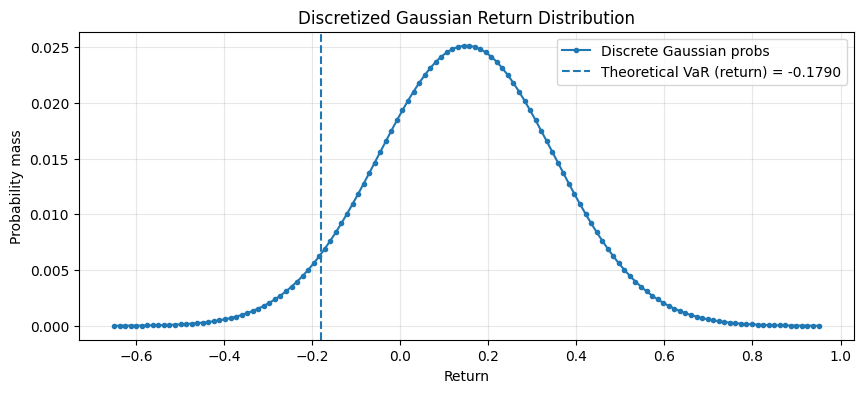

Theoretical VaR (return threshold): -0.17897072539029443
Theoretical VaR (as positive loss): 0.17897072539029443


In [15]:
# Theoretical (continuous) Gaussian VaR: 5th percentile of returns
var_theoretical = stats.norm.ppf(ALPHA_VAR, loc=mu, scale=sigma)

plt.figure(figsize=(10,4))
plt.plot(grid_points, probs, "o-", markersize=3, label="Discrete Gaussian probs")
plt.axvline(var_theoretical, linestyle="--", label=f"Theoretical VaR (return) = {var_theoretical:.4f}")
plt.title("Discretized Gaussian Return Distribution")
plt.xlabel("Return")
plt.ylabel("Probability mass")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("Theoretical VaR (return threshold):", var_theoretical)
print("Theoretical VaR (as positive loss):", -var_theoretical)


In [16]:
# Classical discrete VaR (inclusive):
# find smallest idx where cumulative probability sum_{i<=idx} probs[i] >= ALPHA_VAR
acc = 0.0
VAR_scan = None
VAR_scan_idx = None

for idx, p in enumerate(probs):
    acc += p
    if acc >= ALPHA_VAR:
        VAR_scan = grid_points[idx]
        VAR_scan_idx = idx
        break

print(f"Discrete VaR (inclusive scan) index = {VAR_scan_idx}")
print(f"Discrete VaR (inclusive scan) return threshold = {VAR_scan}")
print(f"Discrete VaR (inclusive scan) as positive loss = {-VAR_scan}")


Discrete VaR (inclusive scan) index = 37
Discrete VaR (inclusive scan) return threshold = -0.1838582677165354
Discrete VaR (inclusive scan) as positive loss = 0.1838582677165354


In [17]:
# Optimized helper classes and functions
class QuantileSearchState:
    """Maintains bracketing interval [L, R] and cache of oracle results."""
    def __init__(self):
        self.L = None
        self.R = None
        self.cache = {}
    
    def query(self, k, oracle_func):
        """Query oracle with caching"""
        if k not in self.cache:
            self.cache[k] = oracle_func(k)
        return self.cache[k]
    
    def get_estimate(self, k):
        return self.cache[k][0] if k in self.cache and isinstance(self.cache[k], tuple) else self.cache[k]
    
    def get_ci_low(self, k):
        return self.cache[k][1] if k in self.cache and isinstance(self.cache[k], tuple) else None
    
    def get_ci_high(self, k):
        return self.cache[k][2] if k in self.cache and isinstance(self.cache[k], tuple) else None

def select_next_index(state, alpha, blend_factor=0.3):
    """Choose next index using interpolation + bisection blend."""
    L, R = state.L, state.R
    k_mid = (L + R) // 2
    
    F_L = state.get_estimate(L)
    F_R = state.get_estimate(R)
    
    if F_L is not None and F_R is not None and F_R > F_L:
        k_interp = L + int((R - L) * (alpha - F_L) / (F_R - F_L))
        k_interp = max(L + 1, min(R - 1, k_interp))
        k = int(blend_factor * k_interp + (1 - blend_factor) * k_mid)
        k = max(L + 1, min(R - 1, k))
    else:
        k = k_mid
    
    return k

def update_brackets(state, k, alpha):
    """Update [L, R] using confidence intervals for robustness."""
    est = state.get_estimate(k)
    ci_low = state.get_ci_low(k)
    ci_high = state.get_ci_high(k)
    
    if ci_high and ci_low:
        if ci_high < alpha:
            state.L = k
        elif ci_low > alpha:
            state.R = k
        else:
            if est < alpha:
                state.L = k
            else:
                state.R = k
    else:
        # Fallback if no CI available (classical case)
        if est < alpha:
            state.L = k
        else:
            state.R = k

def should_terminate(state, alpha, epsilon=0.01):
    """Check if we can stop searching."""
    if state.L + 1 >= state.R:
        return True
    
    F_high_L = state.get_ci_high(state.L)
    F_low_R = state.get_ci_low(state.R)
    
    if F_high_L is not None and F_low_R is not None:
        if F_low_R - F_high_L <= epsilon:
            return True
    
    return False

def value_at_risk_bisection(required_alpha, start_index, alpha_func):
    """
    OPTIMIZED: Interpolative quantile search with theoretical initialization.
    Replaces naive bisection with smart initialization + interpolation.
    """
    state = QuantileSearchState()
    
    print("=== OPTIMIZED INTERPOLATIVE QUANTILE SEARCH ===")
    print(f"Target: alpha={required_alpha:.4f}")
    
    # SMART INITIALIZATION: Use theoretical quantile
    import scipy.stats as stats_local
    theoretical_return = stats_local.norm.ppf(required_alpha, loc=mu, scale=sigma)
    k_init = np.searchsorted(grid_points, theoretical_return)
    k_init = int(max(1, min(N - 2, k_init)))
    
    # Wrap alpha_func to return tuple format (est, ci_low, ci_high)
    def wrapped_func(idx):
        result = alpha_func(idx)
        if isinstance(result, tuple):
            return result
        else:
            # Classical case - return (value, None, None)
            return (result, None, None)
    
    state.query(int(k_init), wrapped_func)
    est_init = state.get_estimate(k_init)
    
    print(f"Theoretical index: {k_init}")
    print(f"  idx={k_init:3d} | est={est_init:.5f}")
    
    # ADAPTIVE STEP SIZING
    error = abs(est_init - required_alpha)
    if error < 0.01:
        step = 2
    elif error < 0.03:
        step = max(2, int(error * N / 0.05))
    else:
        step = max(5, int(error * N / 0.10))
    
    # Establish bracket
    if est_init >= required_alpha:
        state.R = k_init
        k_left = max(0, k_init - step)
        state.query(int(k_left), wrapped_func)
        state.L = k_left if state.get_estimate(k_left) < required_alpha else 0
    else:
        state.L = k_init
        k_right = min(N - 1, k_init + step)
        state.query(int(k_right), wrapped_func)
        if state.get_estimate(k_right) >= required_alpha:
            state.R = k_right
        else:
            state.L = k_right
            k_right2 = min(N - 1, k_right + step)
            state.query(int(k_right2), wrapped_func)
            state.R = k_right2
    
    print(f"\nInitial bracket: [{state.L}, {state.R}] (width={state.R - state.L})")
    print(f"Oracle calls for initialization: {len(state.cache)}\n")
    
    # Main interpolative refinement loop
    iteration = 0
    max_iters = 20
    epsilon = TOLERANCE
    
    while not should_terminate(state, required_alpha, epsilon) and iteration < max_iters:
        interval_size = state.R - state.L
        blend = min(0.9, 0.5 + 0.4 * (1 - interval_size / N))
        
        k = select_next_index(state, required_alpha, blend)
        state.query(int(k), wrapped_func)
        update_brackets(state, k, required_alpha)
        
        iteration += 1
    
    # Find best index
    best_idx = state.L
    best_dist = abs(state.get_estimate(state.L) - required_alpha)
    
    for idx in range(state.L, state.R + 1):
        if idx in state.cache:
            dist = abs(state.get_estimate(idx) - required_alpha)
            if dist < best_dist:
                best_dist = dist
                best_idx = idx
    
    print(f"\n>>> Converged in {iteration} iterations")
    print(f">>> Oracle calls: {len(state.cache)}")
    print(f">>> Best index: {best_idx}")
    print("=" * 50)
    
    return best_idx

# Keep these helper functions
def calc_alpha_classical_inclusive(index: int, probs: list[float]) -> float:
    """Inclusive left-tail CDF at grid index."""
    return sum(probs[:index+1])

def get_initial_index() -> int:
    """Start somewhere not too extreme."""
    return N // 4




In [18]:
start_idx = get_initial_index()
var_idx_bisect_classical = value_at_risk_bisection(
    ALPHA_VAR,
    start_idx,
    lambda i: calc_alpha_classical_inclusive(i, probs)
)

print("Bisection classical VaR index:", var_idx_bisect_classical)
print("Bisection classical VaR return:", grid_points[var_idx_bisect_classical])
print("Bisection classical VaR as positive loss:", -grid_points[var_idx_bisect_classical])


=== OPTIMIZED INTERPOLATIVE QUANTILE SEARCH ===
Target: alpha=0.0500
Theoretical index: 38
  idx= 38 | est=0.05760

Initial bracket: [36, 38] (width=2)
Oracle calls for initialization: 2


>>> Converged in 1 iterations
>>> Oracle calls: 3
>>> Best index: 37
Bisection classical VaR index: 37
Bisection classical VaR return: -0.1838582677165354
Bisection classical VaR as positive loss: 0.1838582677165354


In [19]:
# Global threshold index used by the oracle
GLOBAL_INDEX = 0

@qfunc
def load_distribution(asset: QNum):
    """
    Encodes the classical probs list into amplitudes:
      |psi> = sum_i sqrt(probs[i]) |i>
    """
    inplace_prepare_state(probs, bound=0, target=asset)

@qperm
def payoff(asset: Const[QNum], ind: QBit):
    """
    Inclusive tail event marker:
      ind ^= (asset <= GLOBAL_INDEX)

    After load_distribution + payoff:
      P(ind=1) = sum_{i <= GLOBAL_INDEX} probs[i]
    which is the inclusive CDF at GLOBAL_INDEX.
    """
    ind ^= asset <= GLOBAL_INDEX

@qfunc(synthesize_separately=True)
def state_preparation(asset: QNum, ind: QBit):
    """
    IQAE state preparation:
    1) load distribution in asset
    2) compute tail indicator into ind
    """
    load_distribution(asset)
    payoff(asset, ind)


In [20]:
written_qprog_iqae = False

def calc_alpha_iqae(index: int) -> float:
    """
    Uses IQAE to estimate inclusive CDF at index:
      alpha(index) = P(asset <= index)
    """
    global GLOBAL_INDEX, written_qprog_iqae
    GLOBAL_INDEX = index

    iqae = IQAE(
        state_prep_op=state_preparation,
        problem_vars_size=num_qubits,
        constraints=Constraints(max_width=28),
        preferences=Preferences(machine_precision=num_qubits),
    )

    if not written_qprog_iqae:
        written_qprog_iqae = True
        show(iqae.get_qprog())

    # epsilon = target absolute error on probability estimate
    # alpha   = failure probability (confidence = 1-alpha)
    iqae_res = iqae.run(epsilon=0.02, alpha=0.01)

    est = iqae_res.estimation
    ci = np.array([x for x in iqae_res.confidence_interval])

    print(f"IQAE at index={index}: alpha≈{est:.5f}, CI={ci}")
    return est


In [21]:
start_idx = get_initial_index()

var_idx_iqae = value_at_risk_bisection(
    required_alpha=ALPHA_VAR,
    start_index=start_idx,
    alpha_func=calc_alpha_iqae
)

print("\n=== IQAE RESULTS ===")
print("IQAE VaR index:", var_idx_iqae)
print("IQAE VaR return threshold:", grid_points[var_idx_iqae])
print("IQAE VaR as positive loss:", -grid_points[var_idx_iqae])


=== OPTIMIZED INTERPOLATIVE QUANTILE SEARCH ===
Target: alpha=0.0500
Quantum program link: https://platform.classiq.io/circuit/393kaSvxwpQsbIrGXFpTdCrqeWe
IQAE at index=38: alpha≈0.05944, CI=[0.05293995 0.06594164]
Theoretical index: 38
  idx= 38 | est=0.05944
IQAE at index=36: alpha≈0.04488, CI=[0.04086275 0.0489057 ]

Initial bracket: [36, 38] (width=2)
Oracle calls for initialization: 2

IQAE at index=37: alpha≈0.05249, CI=[0.0475353  0.05745246]

>>> Converged in 1 iterations
>>> Oracle calls: 3
>>> Best index: 37

=== IQAE RESULTS ===
IQAE VaR index: 37
IQAE VaR return threshold: -0.1838582677165354
IQAE VaR as positive loss: 0.1838582677165354


In [22]:
print("\n=== FINAL COMPARISON ===")
print("Inclusive scan VaR index:", VAR_scan_idx)
print("Inclusive scan VaR return:", VAR_scan)

print("Classical bisection VaR index:", var_idx_bisect_classical)
print("Classical bisection VaR return:", grid_points[var_idx_bisect_classical])

print("IQAE VaR index:", var_idx_iqae)
print("IQAE VaR return:", grid_points[var_idx_iqae])


print("Theoretical continuous Gaussian VaR return:", var_theoretical)



=== FINAL COMPARISON ===
Inclusive scan VaR index: 37
Inclusive scan VaR return: -0.1838582677165354
Classical bisection VaR index: 37
Classical bisection VaR return: -0.1838582677165354
IQAE VaR index: 37
IQAE VaR return: -0.1838582677165354
Theoretical continuous Gaussian VaR return: -0.17897072539029443



--- Scaling experiment threshold ---
threshold_idx: 37
threshold_return: -0.1838582677165354

--- Running sweep ---
eps=0.200000  1/eps=    5.0  mean_calls=   2048.0  std=    0.0  mean(CI/2)=0.03597  mean(CI/2)/eps=0.18
   example k schedule: [0]
eps=0.100000  1/eps=   10.0  mean_calls=   5734.4  std= 3009.9  mean(CI/2)=0.01792  mean(CI/2)/eps=0.18
   example k schedule: [0, 2]
eps=0.050000  1/eps=   20.0  mean_calls=   7782.4  std=  819.2  mean(CI/2)=0.00496  mean(CI/2)/eps=0.10
   example k schedule: [0, 2]
eps=0.025000  1/eps=   40.0  mean_calls=   7372.8  std= 1003.3  mean(CI/2)=0.00520  mean(CI/2)/eps=0.21
   example k schedule: [0, 2]
eps=0.012500  1/eps=   80.0  mean_calls=   8192.0  std=    0.0  mean(CI/2)=0.00474  mean(CI/2)/eps=0.38
   example k schedule: [0, 2]
eps=0.006250  1/eps=  160.0  mean_calls=  67584.0  std= 7984.6  mean(CI/2)=0.00036  mean(CI/2)/eps=0.06
   example k schedule: [0, 2, 28]
eps=0.003125  1/eps=  320.0  mean_calls=  64307.2  std= 9304.3  mean(CI/2)=0.0

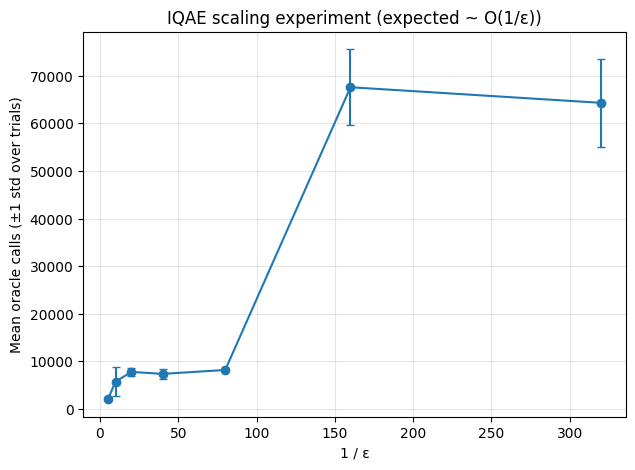


Linear fit on inv_eps >= 40:
  mean_calls ≈ 222.25*(1/ε) + 3526.12


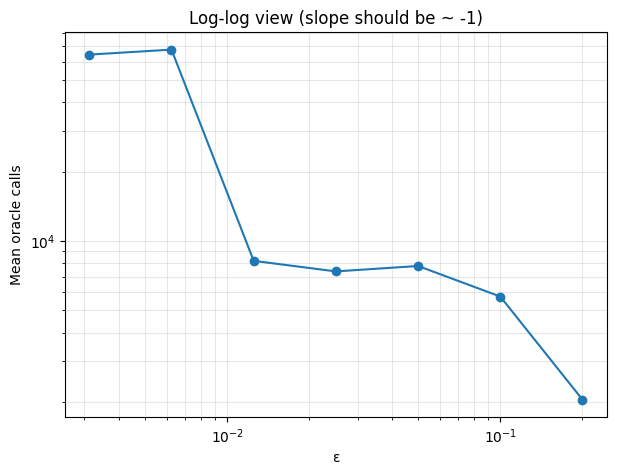

log-log slope (on same mask): -1.24  (target ~ -1)


In [23]:
# ============================================================
# IQAE O(1/ε) SCALING EXPERIMENT
# Fix ONE threshold, vary ε, measure oracle calls
# ============================================================

def iqae_total_oracle_calls(iqae_result):
    """
    Total oracle calls proxy (same convention as your dummy code):
      total_calls = Σ_over_iterations (grover_iterations + 1) * shots
    Returns (total_calls, total_shots, ks, shots_per_iter)
    """
    total_calls = 0
    total_shots = 0
    ks = []
    shots_list = []

    for it in iqae_result.iterations_data:
        k = it.grover_iterations
        counts = it.sample_results.counts
        shots = sum(counts.values())

        ks.append(k)
        shots_list.append(shots)

        total_shots += shots
        total_calls += (k + 1) * shots

    return int(total_calls), int(total_shots), ks, shots_list


# --- Fix a single threshold near VaR (inclusive scan index) ---
threshold_idx = VAR_scan_idx
GLOBAL_INDEX = threshold_idx
print("\n--- Scaling experiment threshold ---")
print("threshold_idx:", threshold_idx)
print("threshold_return:", grid_points[threshold_idx])

# --- Build IQAE once (important!) ---
iqae = IQAE(
    state_prep_op=state_preparation,
    problem_vars_size=num_qubits,
    constraints=Constraints(max_width=28),
    preferences=Preferences(machine_precision=num_qubits),
)

alpha_fail = 0.01           # fixed confidence across all runs
eps_list = [0.2 / (2**n) for n in range(0,7)]  # 0.2 -> 0.003125
TRIALS = 5                  # increase for smoother averages

avg_records = []

print("\n--- Running sweep ---")
for eps in eps_list:
    costs = []
    ci_halfwidths = []
    ks_last = None

    for t in range(TRIALS):
        res = iqae.run(epsilon=eps, alpha=alpha_fail)

        L, U = res.confidence_interval
        ci_half = (U - L) / 2

        calls, shots, ks, shots_per_iter = iqae_total_oracle_calls(res)

        costs.append(calls)
        ci_halfwidths.append(ci_half)
        ks_last = ks  # just keep one example schedule to print

    mean_c = float(np.mean(costs))
    std_c  = float(np.std(costs))
    mean_ci = float(np.mean(ci_halfwidths))

    avg_records.append({
        "epsilon": float(eps),
        "inv_epsilon": float(1/eps),
        "mean_calls": mean_c,
        "std_calls": std_c,
        "mean_ci_halfwidth": mean_ci,
        "example_ks": ks_last,
    })

    print(f"eps={eps:.6f}  1/eps={1/eps:7.1f}  mean_calls={mean_c:9.1f}  std={std_c:7.1f}  "
          f"mean(CI/2)={mean_ci:.5f}  mean(CI/2)/eps={mean_ci/eps:.2f}")
    print("   example k schedule:", ks_last)


# --- Plot mean oracle calls vs 1/ε ---
inv_eps = np.array([r["inv_epsilon"] for r in avg_records], float)
mean_calls = np.array([r["mean_calls"] for r in avg_records], float)
std_calls  = np.array([r["std_calls"] for r in avg_records], float)

plt.figure(figsize=(7,5))
plt.errorbar(inv_eps, mean_calls, yerr=std_calls, fmt="o-", capsize=3)
plt.xlabel("1 / ε")
plt.ylabel("Mean oracle calls (±1 std over trials)")
plt.title("IQAE scaling experiment (expected ~ O(1/ε))")
plt.grid(True, alpha=0.3)
plt.show()

# --- Fit only the "large 1/ε" regime (overhead dominates small 1/ε) ---
mask = inv_eps >= 40   # you can change to 80 if you want stricter asymptotic fit
m, b = np.polyfit(inv_eps[mask], mean_calls[mask], 1)
print(f"\nLinear fit on inv_eps >= 40:")
print(f"  mean_calls ≈ {m:.2f}*(1/ε) + {b:.2f}")

# --- Log-log slope check (should trend toward -1) ---
eps_arr = np.array([r["epsilon"] for r in avg_records], float)

plt.figure(figsize=(7,5))
plt.loglog(eps_arr, mean_calls, "o-")
plt.xlabel("ε")
plt.ylabel("Mean oracle calls")
plt.title("Log-log view (slope should be ~ -1)")
plt.grid(True, which="both", alpha=0.3)
plt.show()

slope, intercept = np.polyfit(np.log(eps_arr[mask]), np.log(mean_calls[mask]), 1)
print(f"log-log slope (on same mask): {slope:.2f}  (target ~ -1)")
